# Multiclass classification 2: Fit and score

This notebook comes after:

- Multiclass_classification_1_Split_and_scale.ipynb

This notebook assumes you have some familiarity with:

- Basic Python syntax and functions.
- Numerics and visualization with NumPy and `matplotlib` or `seaborn`.
- Exploratory data analysis with Pandas.
- The essential concepts of supervised machine learning.
- The fundamentals of machine learning algorithms.

If you're a bit short on a couple of these elements, not to worry. There are other courses that cover them, but you might find that we breeze past some topics in this class. Ask questions and follow links!

---

## Unfreezing the data

In [1]:
import numpy as np

f = np.load("All_data.npz", allow_pickle=True)
X_train, X_test, y_train, y_test, wells = [f.get(file) for file in f.files]

X_train[:5]

array([[7.74500000e+01, 2.39349994e+03, 4.60000000e+00, 6.64000000e-01],
       [7.82600000e+01, 2.41611981e+03, 4.10000000e+00, 6.61000000e-01],
       [7.90500000e+01, 2.40457606e+03, 3.60000000e+00, 6.58000000e-01],
       [8.61000000e+01, 2.39324907e+03, 3.50000000e+00, 6.55000000e-01],
       [7.45800000e+01, 2.38260260e+03, 3.40000000e+00, 6.47000000e-01]])

In [2]:
import sklearn

print(sklearn.__version__)

# Make sure we can see all of the model details.
sklearn.set_config(print_changed_only=False)

0.24.2


---

## The support vector machine

For the purposes of this class, we're going to focus on the suuport vector machine, or SVM. This is a reliable classifier with just enough complexity to allow us to explore several concepts in machine learning.

In [3]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

model = SVC()

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

model.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

But training this way doesn't give us a way to validate, because we used all our data. Recall that we want to use cross-validation. That means we need to do more work:

- Split out each well in turn.
- For each well:
  - Its data will be for validation and the complement of the data will be for training.
  - Scale the training and validation data.
  - Train a model.
  - Predict the validation chunk,and store the prediction.
  - Record the validation score.

### EXERCISE

Loop over the wells in the `wells` array, taking the rows for each well as `X` and `y`, fitting a model for those data, and collecting a score and the predictions.

You will find this function helpful:

```python
def iter_groups(groups):
    """
    Allow iterating over groups, getting boolean array for each.
    
    Example:
    >>> for group in iter_groups([1, 1, 1, 2, 2]):
    ...     print(group)
    [ True  True  True False False]
    [False False False  True  True]
    """
    for group in np.unique(groups):
        yield groups == group
```

Your function might start like so:

```python
def cross_validate(model, X_train, y_train, groups, scaler):

    # YOUR CODE HERE
    
    return scores, preds
```

In [4]:
# YOUR CODE HERE



In [5]:
from sklearn.metrics import accuracy_score

def iter_groups(groups):
    """
    Allow iterating over groups, getting boolean array for each.
    
    Example:
    >>> for group in iter_groups([1, 1, 1, 2, 2]):
    ...     print(group)
    [ True  True  True False False]
    [False False False  True  True]
    """
    for group in np.unique(groups):
        yield groups == group

# Could also do this with a generator expression, e.g.
# for group in (groups==group for group in np.unique(groups)):
#     model.fit... etc.
        
def cross_validate(model, X_train, y_train, groups, scaler):
    """
    Do CV on model using groups to split the data.
    
    Enhancements:
      - Could return a dict showing which group (well) goes with which score.
    """
    scores, preds = [], []
    for group in iter_groups(groups):
        X_train_group, y_train_group = X_train[~group],  y_train[~group]
        X_train_scaled = scaler.fit_transform(X_train_group)
        model.fit(X_train_scaled,  y_train_group)
        y_pred_group = model.predict(scaler.transform(X_train[group]))
        preds.append(y_pred_group)
        scores.append(accuracy_score(y_train[group], y_pred_group))
    return np.array(scores), np.hstack(preds)
    
cross_validate(SVC(), X_train, y_train, groups=wells, scaler=StandardScaler())

(array([0.59057072, 0.42540323, 0.72885033, 0.64794816, 0.69638554,
        0.71125265]),
 array(['siltstone', 'siltstone', 'siltstone', ..., 'limestone',
        'limestone', 'limestone'], dtype=object))

In [6]:
# To implement other group types...
# E.g. to split into 5 folds:
n = 5
N, M = X_train.shape
folds = np.repeat(range(n), N//n)[:N]
folds

# If you want random folds, do np.random.shuffle on this.

array([0, 0, 0, ..., 4, 4, 4])

---

## Pipelines

Pipelines are very useful objects in `sklearn`. They will allow us to do a lot of data manipulation in a completely dynamic way. For example, we can add features without creating new columns in our dataframes or arrays, and we can scale our data right before the model sees it — so we can't forget it or mess it up!

There are two ways to use pipelines. Which one you choose often just depends on how you want to name your steps:

- `make_pipeline`: when you're okay with the default names for steps.
- `Pipeline`: when you want to specify your own names for steps.

We'll start with `make_pipeline` because it lets us write a bit less code.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(),
                      SVC(),
                     )

### EXERCISE

Modify our function to use this new pipeline instead of the model + scaler.

In [8]:
# YOUR CODE HERE



In [9]:
def cross_validate(model, X_train, y_train, groups):
    """
    Do CV on model using groups to split the data.
    """
    scores, preds = [], []
    for group in iter_groups(groups):
        X_train_group, y_train_group = X_train[~group],  y_train[~group]
        model.fit(X_train_group,  y_train_group)
        y_pred_group = model.predict(X_train[group])
        preds.append(y_pred_group)
        scores.append(accuracy_score(y_train[group], y_pred_group))
    return np.array(scores), np.hstack(preds)
    
cross_validate(model, X_train, y_train, groups=wells)

(array([0.59057072, 0.42540323, 0.72885033, 0.64794816, 0.69638554,
        0.71125265]),
 array(['siltstone', 'siltstone', 'siltstone', ..., 'limestone',
        'limestone', 'limestone'], dtype=object))

## Use more of `sklearn`'s machinery

When using cross-validation, the easiest and safest thing to do is to let `sklearn` do the fitting via a cross-validation function. So we won't call `model.fit()` and `model.predict()`, but `sklearn` is going to do it.

In [10]:
from sklearn.model_selection import cross_val_score

# Reinstantiate, so there's no confusion about the model's state.
model = make_pipeline(StandardScaler(),
                      SVC(),
                     )

scores = cross_val_score(model, X_train, y_train)
scores

array([0.67343173, 0.68265683, 0.6199262 , 0.6697417 , 0.69685767])

Notice that there are five scores, because the default cross-validation happens across 5 random splits:

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross validation,
        - int, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

        For int/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used. These splitters are instantiated
        with `shuffle=False` so the splits will be the same across calls.

So the 5 splits are stratified (they take the classes into account), but they are not in line with our wells. So we'll usually have a well divided across two splits, which is a risk for leakage.

In [11]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()

scores = cross_val_score(model, X_train, y_train, cv=logo, groups=wells)
scores

array([0.59057072, 0.42540323, 0.72885033, 0.64794816, 0.69638554,
       0.71125265])

In [12]:
import numpy as np

# According to the source code, the scores will be ordered in the same
# way that np.unique() orders them, alphabetically in this case.
# https://github.com/scikit-learn/scikit-learn/blob/80598905e/sklearn/model_selection/_split.py#L1159

np.unique(wells)

array(['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN',
       'SHRIMPLIN'], dtype=object)

Remember the distribution of facies in the well?

Why is the Cross H Cattle score so bad?

### `predict`

In [13]:
from sklearn.model_selection import cross_val_predict



In [14]:
y_pred = cross_val_predict(model, X_train, y_train, cv=logo, groups=wells, n_jobs=6)

In [15]:
y_pred == y_train

# Then: sum(y_pred == y_train) / y_train.size

array([False,  True,  True, ..., False, False, False])

In [16]:
for pair in zip(y_pred, y_train):
    print(pair)

('limestone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('limestone', 'siltstone')
('siltstone', 'siltstone')
(

Another approach might involve plotting, which will need numbers instead of strings... but often we'd like numbers anyway. 

We could use the `LabelEncoder` in sklearn, but I want to control the order, so let's do this:

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class OrderedEncoder(LabelEncoder):
    def fit(self, y):
        """
        Like the LabelEncoder, but preserves the order
        in the label vector.
        """
        y = column_or_1d(y, warn=True)
        
        # classes_ must be an array for the inverse transform.
        self.classes_ = np.array(list(dict.fromkeys(y)))
        return self

legend = {
    'sandstone': '#F4D03F',
    'siltstone': '#F3E8BF' ,
    'mudstone': '#C1C1C1',
    'wackestone': '#728393',
    'limestone': '#2E86C1',
    'dolomite': '#C186C1'
}

enc = OrderedEncoder()

enc.fit(list(legend))

y_train_int = enc.transform(y_train)
y_pred_int = enc.transform(y_pred)

y_pred_int

array([4, 1, 1, ..., 3, 3, 3])

Plotting a 1D array as a ribbon image is not difficult, once we reshape into a 'column' vector (a greyscale image of width 1, basically). We'll use a function from `mlutils` that makes the whole thing a bit easier.

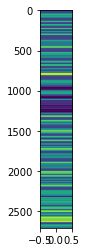

In [18]:
import matplotlib.pyplot as plt

plt.imshow(y_train_int.reshape(-1, 1), aspect=0.0025)

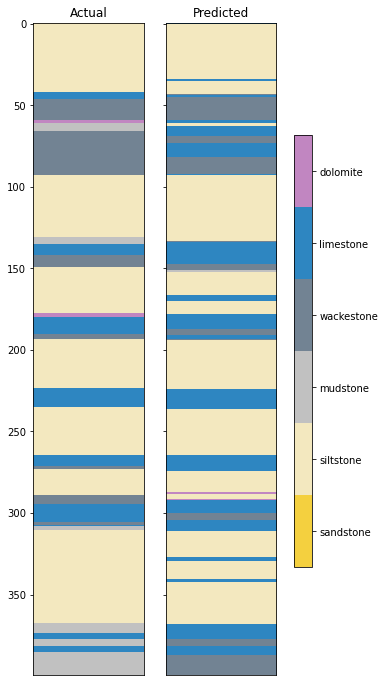

In [19]:
from mlutils import plot_ribbons

plot_ribbons(y_train_int, y_pred_int, s=(None, 400), legend=legend)

## Probabilistic predictions

Many, but not all, models provide probabilistic classifications. When you call `predict()`, you're getting the `argmax` of this array†.

† Sort of... the probabilities do not necessarily exactly match the predictions made by the SVM, which depend on the distance to the decision hypersurface in a high-dimenional space. The process that estimates probability, Platt scaling, is not totally predictable; [see the documentation.](https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities)

In [20]:
m = make_pipeline(StandardScaler(), SVC(probability=True))

y_prob = cross_val_predict(m, X_train, y_train,
                           cv=LeaveOneGroupOut(), groups=wells,
                           method='predict_proba')

np.set_printoptions(precision=4)
y_prob[:5]

array([[0.0141, 0.6445, 0.0906, 0.0015, 0.0587, 0.1905],
       [0.0112, 0.2245, 0.1257, 0.0134, 0.5109, 0.1144],
       [0.003 , 0.0202, 0.072 , 0.054 , 0.824 , 0.0269],
       [0.003 , 0.0193, 0.0794, 0.0549, 0.8168, 0.0266],
       [0.0014, 0.0069, 0.0639, 0.0774, 0.8336, 0.0169]])

### ⚠️ Avoid `model.score()`

You might see `model.score()` in tutorials or the `sklearn` docs. But note that when using cross-validation `model.score()` can only tell you how the current model does on the training data, like `X_train` (we're not allowed to look at `X_test` yet). We can't just fit the model to the training data, because that would only give us the training score.

In our case, we don't have a validation set we can do intermediate validation on &mdash; because we're using cross-validation. But we can get the score of the cross-validation prediction.

In [20]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_train, y_pred)
print(f"The validation accuracy is {score*100:.1f}%")

The validation accuracy is 63.1%


## Accuracy is (usually) not enough

The _accuracy_ is just one of the _metrics_ we can use to check the quality of the predictions. There are a large number of different metrics and depending on your data and problem you may need to find the one that adjusts better to your needs.

In a binary classification with balanced classes, the accuracy score is useful. But... in general accuracy can be misleading, especially in datasets with unbalanced classes. A more robust metric is the `F1` metric. It combines the `precision` score and `recall` for each class:

$$ \mathrm{F1} = \frac{2}{\frac{1}{\mathrm{precision}}+ \frac{1}{\mathrm{recall}}} $$

Scikit-learn gives a nice summary of these three metrics using `classification_report`.

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred, digits=3, ))

              precision    recall  f1-score   support

    dolomite      0.481     0.160     0.241        81
   limestone      0.661     0.653     0.657       551
    mudstone      0.359     0.176     0.236       375
   sandstone      0.000     0.000     0.000       170
   siltstone      0.713     0.954     0.816      1141
  wackestone      0.431     0.465     0.448       391

    accuracy                          0.631      2709
   macro avg      0.441     0.401     0.400      2709
weighted avg      0.561     0.631     0.582      2709



Notice the different performance on different lithologies!

We can also use `cross_validate()` to get at any set of scores, including the training score. We'll do this in the next notebook.

#### What on earth is macro average?

From [this nice answer](https://datascience.stackexchange.com/a/24051/70391) on SO:

>  A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average [`sklearn` calls it the weighted average] will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average [weighted average] is preferable if you suspect there might be class imbalance.

Since we almost always have imbalanced classes, we should usually prefer the weighted average.

## Dealing with class imbalance

"Class imbalance" means that we have more of some labels than others. This does lead to problems in both training and evaluation.

- Collect more data, if it's an option.
- Choose correct evaluation metrics (some attempt to handle imbalance, eg F1 vs accuracy).
- Choose models that handle imbalance well, e.g. tree-based models. (Some implementations, like XGBoost, try to implicitly handle imbalance.)
- When splitting into holdout or cross-validation datasets, use _stratified_ variants. Note that this is the default behaviour in Scikit-Learn's cross-validation functions, but _not_ in `train_test_split()`.
- If the problem is an over-abundant class, split that class into groups, and mix with the rare class (which you repeat in each group).
- If the problem is an over-abundant class, under-sample the abundant class(es) -- but this means losing the learning effect from those samples.
- If the problem is an over-abundant class, cluster the abundant class into _r_ clusters (where _r_ is the number of instances in the rare class). In other words, you're sort of undersampling without losing the information.
- If the problem is an _under_-abundant class, over-sample that rare class, e.g. by repeating or fuzzing (adding some random noise in each dimension).
- Simulate synthetic samples for the rare class (e.g. with SMOTE).
- Use a custom cost function, or a cost matrix, that penalizes errors on the rare class(es).

I found this library, which could be useful if you're considering over- or under-sampling as a strategy: https://github.com/scikit-learn-contrib/imbalanced-learn

## Confusion matrix

The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is another option: which classes are being confused with which?  Scikit-learn has a function for that!

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred)

array([[  13,   25,   10,    1,   30,    2],
       [   5,  360,   39,    0,   57,   90],
       [   2,   35,   66,    0,  134,  138],
       [   0,    0,    0,    0,  170,    0],
       [   3,   27,   10,    3, 1088,   10],
       [   4,   98,   59,    0,   48,  182]])

But as you can see, it's not very clear... What does each row/column represent? There's another function that's a bit more informative, `sklearn.metrics.plot_confusion_matrix()` but it doesn't quite work with cross validation pipelines. So we made one that does:

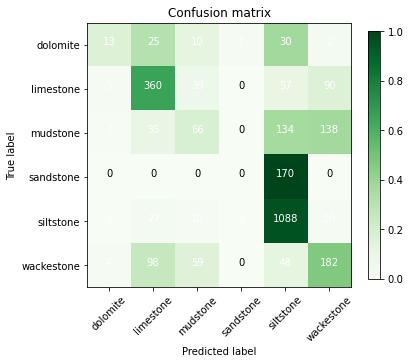

In [23]:
import mlutils

mlutils.plot_confusion_matrix(y_train, y_pred)

### Precision-recall, sensitivity-specificity, etc.

**Accuracy** is simply the number of correct predictions divided by the total number of predictions. The number and types of error don't come into it. There's one number for the entire prediction. And it omits a big part of the story.

There are various ways to capture the kinds of errors the classifier makes. Confusingly, they all have synonyms too (shown here)...

- **Precision, or positive predictive value**: of the instances predicted as class Ⓐ, what proportion were correct?
- **Recall, sensitivity, hit rate, or true positive rate**: what proportion of all Ⓐ instances were correctly predicted as Ⓐ?
- **Specificity, selectivity, or true negative rate ( = 1 - false positive rate)**: what proportion of all non-Ⓐ instances were correctly predicted as non-Ⓐ?

We tend to consider either precision and recall, or sensitivity (the same as recall) and specificity. There's a trade-off between the two: better recall involves giving up some precision and vice-versa.

The ROC curve tries to capture this trade-off. Look for [the binary classification notebook](Binary_classification.ipynb).

### Exercise

Consider this classifier:

<img src="../images/sand_limestone_classifier.svg" />


- What is the **accuracy** of this classifier?
- What is the **precision** for limestone? 
- What is the **recall** for sand? 

Note that there are 31 limestone points and 55 sandstone points in the validation data.

Use these formulae relating the metrics to the numbers of true positives (tp) to false positives (fp) and false negatives (fn):

$$ \mathrm{accuracy} = \frac{\mathrm{correct}\ \mathrm{predictions}}{\mathrm{all}\ \mathrm{points}} $$

$$ \mathrm{precision} = \frac{\mathrm{tp}}{\mathrm{tp}\ +\ \mathrm{fp}} $$

$$ \mathrm{recall} = \frac{\mathrm{tp}}{\mathrm{tp}\ +\ \mathrm{fn}} $$

In [43]:
def report(tp, fp, tn, fn):
    support = tp + fn
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    string = f"""    Support:   {support}
    Precision: {precision:.2f}
    Recall:    {recall:.2f}
    F1:        {f1:.2f}
    Accuracy:  {accuracy:.2f}
    """

    return string

In [44]:
# limestone
tp, fp = 24, 1
tn, fn = 54, 7

print(report(tp, fp, tn, fn))

    Support:   31
    Precision: 0.96
    Recall:    0.77
    F1:        0.86
    Accuracy:  0.91
    


In [45]:
# sandstone
tp, fp = 54, 7
tn, fn = 24, 1

print(report(tp, fp, tn, fn))

    Support:   55
    Precision: 0.89
    Recall:    0.98
    F1:        0.93
    Accuracy:  0.91
    


In [46]:
from sklearn.metrics import classification_report

val =         31*['limestone']            +         55*['sandstone']
pred = 24*['limestone'] + 7*['sandstone'] + 54*['sandstone'] + 1*['limestone']

print(classification_report(val, pred, digits=2))

              precision    recall  f1-score   support

   limestone       0.96      0.77      0.86        31
   sandstone       0.89      0.98      0.93        55

    accuracy                           0.91        86
   macro avg       0.92      0.88      0.89        86
weighted avg       0.91      0.91      0.90        86



## Subtlety in the score

Let's look at two types of error. 

Both of these are errors in the eyes of the ML algorithm, but not necessarily in the eyes of the geologist.

First: predicting 8 (maybe coarse sand) instead of 7 (fine sand) should not be as bad as predicting 2 (say, basalt) instead of 7. How could we fix this?

<img src="../images/classification_errors.png" />

## The baseline: a dummy classifier

The dummy classifier tries to answer the question, "How well can I do with zero intelligence?". In other words, given the relative proportions of facies, what would you expect from random weighted guesses?

In [25]:
from sklearn.dummy import DummyClassifier

dummy = make_pipeline(DummyClassifier())

y_pred = cross_val_predict(dummy, X_train, y_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

    dolomite       0.00      0.00      0.00        81
   limestone       0.00      0.00      0.00       551
    mudstone       0.00      0.00      0.00       375
   sandstone       0.00      0.00      0.00       170
   siltstone       0.42      1.00      0.59      1141
  wackestone       0.00      0.00      0.00       391

    accuracy                           0.42      2709
   macro avg       0.07      0.17      0.10      2709
weighted avg       0.18      0.42      0.25      2709



/home/matt/miniconda3/envs/geoml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matt/miniconda3/envs/geoml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matt/miniconda3/envs/geoml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In essence, if I can't beat this, then my model is definitely not useful.

Another measure of 'useful' is whether the classifier can beat a human (but don't forget that these labels were generated by a human!).

---

# QUIZ!

<hr />

<p style="color:gray">©2021&ndash;2022 Agile Geoscience. Licensed CC-BY.</p>